In [1]:
!pip install python-Levenshtein

import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt

You should consider upgrading via the '/export/usuarios_ml4ds/lbartolome/topicmodeler/.venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
mallet_path = '/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet'

In [3]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [4]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

## **1. Creation of synthetic corpus**


---

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

We consider two scenarios for the last step (documents generation) according to whether we are utilzing LDA or ProdLDA's generative process.

* **According to LDA's generative process**
    **for** each document $d$ **do**  
    &nbsp;&nbsp;Draw topic distribution $\theta \sim Dirichlet(\alpha)$  
    &nbsp;&nbsp;&nbsp;&nbsp;**for** each word at position $n$ **do**  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample topic $z_n \sim Multinomial(1,\theta)$  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample word $w_n \sim Multinomial(1, \beta_{z_n})$  
    &nbsp;&nbsp;&nbsp;&nbsp;**end**  
    **end**

    where the distribution of $w_n \sim \beta$, $\theta$ is $Multinomial(1, \beta\theta)$

* **According to ProdLDA generative process**
    In comparisson to LDA's generative process:
    - $\beta$ is **unnormalized**
    - the conditional distribution of wn is defined as $w_n \mid \beta, \theta \sim Multinomial(1, \sigma(\beta\theta))$

### *Auxiliary functions for synthetic corpus generation*

In [2]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [3]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

In [7]:
def plot_thetas(thetas):
    thetas_thr = 3e-3
    allvalues = np.sort(thetas.flatten())
    step = int(np.round(len(allvalues) / 1000))
    plt.semilogx(allvalues[::step], (100 / len(allvalues))
                 * np.arange(0, len(allvalues))[::step])
    plt.semilogx([thetas_thr, thetas_thr], [0, 100], 'r')

step 100


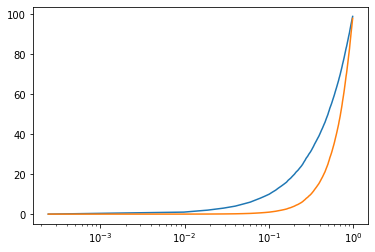

In [8]:
v = np.random.rand(10000)
allvalues = np.sort(v.flatten())
#print(allvalues)
step = int(np.round(len(allvalues) / 100))
print("step", step)
plt.semilogx(allvalues[::step], (100 / len(allvalues))
             * np.arange(0, len(allvalues))[::step])
plt.semilogx(allvalues[::step], (100 / sum(allvalues))
             * np.cumsum(allvalues)[::step])

### *Topic modeling and Centralized settings*

In [4]:
n_nodes = 5

In [5]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 50/n_topics#1/n_topics
n_docs = 1000
n_docs_inf = 1000
n_docs_global_inf = int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [6]:
# Centralized settings
frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

### *1.1. Generation of training + validation corpus*

We generate `ndocs + n_docs_inf` documents with the same document-topic proportions for each node, from which `ndocs`are used for training and `n_docs_inf` for validation.

`inf1`: Inference corpus of size `n_nodes * n_docs_inf`, each `n_docs_inf` belonging to a different node.

`inf2`: Inference corpus of size `ndocs`, generated from the concatenation of the first `int(n_docs / n_nodes)` with `n_docs_inf`of each node.

In [7]:
topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)

Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.04it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:22<00:00, 24.22it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:53<00:00, 37.42it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.67it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.93it/s]


In [13]:
inf1 = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_inf)]]
print(len(inf1))

5000


In [14]:
inf2 = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
print(len(inf2))

for i in range(len(doc_topics_all)):
    if i == 0:
        inf2_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
    else:
        inf2_doc_topics = np.concatenate((inf2_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
print(inf2_doc_topics.shape)

1000
(1000, 50)


## **2. Mallet**


---

### *Auxiliary functions*

In [15]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [16]:
def train(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus txt file
    corpusFile = modeldir.joinpath("corpus.txt")
    with open(corpusFile, 'w') as fout:
        [fout.write(str(idx) + ' 0 ' + ' '.join(doc) + '\n') for idx,doc in enumerate(corpus)]
    
    # Create corpus mallet file
    corpusMallet = modeldir.joinpath('corpus.mallet')

    cmd = mallet_path + \
        ' import-file --preserve-case --keep-sequence ' + \
        '--remove-stopwords --token-regex "' + '[\p{L}\p{N}][\p{L}\p{N}\p{P}]*' + \
        '" --input %s --output %s'
    cmd = cmd % (corpusFile, corpusMallet)

    try:
        print(f'-- -- Running command {cmd}')
        check_output(args=cmd, shell=True)
    except:
        print('-- -- Mallet failed to import data. Revise command')
    
    # Perform Mallet train
    with open(configFile, 'w', encoding='utf8') as fout:
        fout.write('input = ' + corpusMallet.resolve().as_posix() + '\n')
        fout.write('num-topics = ' + str(n_topics) + '\n')
        fout.write('alpha = 1\n')
        fout.write('optimize-interval = 10\n')
        fout.write('num-threads = 4\n')
        fout.write('num-iterations = 1000\n')
        fout.write('doc-topics-threshold = 0\n')
        fout.write('output-doc-topics = ' +
                    modeldir.joinpath('doc-topics.txt').resolve().as_posix() + '\n')
        fout.write('word-topic-counts-file = ' +
                   modeldir.joinpath('word-topic-counts.txt').resolve().as_posix() + '\n')
        fout.write('output-topic-keys = ' +
                   modeldir.joinpath('topickeys.txt').resolve().as_posix() + '\n')
        fout.write('inferencer-filename = ' + 
                   modeldir.joinpath('inferencer.mallet').resolve().as_posix() + '\n')
    cmd = mallet_path + ' train-topics --config ' + configFile.resolve().as_posix()
    print(cmd)
    try:
        print(
            f'-- -- Training mallet topic model. Command is {cmd}')
        check_output(args=cmd, shell=True)
    except:
        print('-- -- Model training failed. Revise command')
    
    return modeldir

In [17]:
def extractPipe(modeldir):
    
    path_corpus = modeldir.joinpath('corpus.mallet')
    if not path_corpus.is_file():
        print('-- Pipe extraction: Could not locate corpus file')
        return

    # Create auxiliary file with only first line from the original corpus file
    path_txt = modeldir.joinpath('corpus.txt')
    with path_txt.open('r', encoding='utf8') as f:
        first_line = f.readline()
        
    path_aux = modeldir.joinpath('corpus_aux.txt')
    with path_aux.open('w', encoding='utf8') as fout:
        fout.write(first_line + '\n')

    # We perform the import with the only goal to keep a small file containing the pipe
    print('-- Extracting pipeline')
    path_pipe = modeldir.joinpath('import.pipe')
    
    cmd = mallet_path + \
        ' import-file --use-pipe-from %s --input %s --output %s'   
    cmd = cmd % (path_corpus, path_aux, path_pipe)

    try:
        print(f'-- Running command {cmd}')
        check_output(args=cmd, shell=True)
    except:
        print('-- Failed to extract pipeline. Revise command')

    # Remove auxiliary file
    path_aux.unlink()

    return 

In [18]:
def inference(modeldir, corpus_inf):

    # A proper corpus should exist with the corresponding ipmortation pipe
    path_pipe = modeldir.joinpath('import.pipe')
    if not path_pipe.is_file():
        print('-- Inference error. Importation pipeline not found')
        return

    # Get inferencer
    inferencer = modeldir.joinpath('inferencer.mallet')
    
    # File for performing inference on
    corpus_file = modeldir.joinpath("corpus_inf.txt")
    with open(corpus_file, 'w') as fout:
        [fout.write(str(idx) + ' 0 ' + ' '.join(doc) + '\n') for idx,doc in enumerate(corpus_inf)]

    # The following files will be generated in the same folder
    corpus_mallet_inf = modeldir.joinpath('corpus_inf.mallet')  # mallet serialized
    doc_topics_file = modeldir.joinpath('doc-topics-inf.txt')

    # Import data to mallet
    print('-- Inference: Mallet Data Import')
   
    cmd = mallet_path + \
        ' import-file --use-pipe-from %s --input %s --output %s'
    cmd = cmd % (path_pipe, corpus_file, corpus_mallet_inf)

    try:
        print(f'-- Running command {cmd}')
        check_output(args=cmd, shell=True)
    except:
        print(
            '-- Mallet failed to import data. Revise command')
        return

    # Get topic proportions
    print('-- Inference: Inferring Topic Proportions')
    num_iterations = 100
    doc_topic_thr = 0

    cmd = mallet_path + \
        ' infer-topics --inferencer %s --input %s --output-doc-topics %s ' + \
        ' --doc-topics-threshold ' + str(doc_topic_thr) + \
        ' --num-iterations ' + str(num_iterations)
    cmd = cmd % (inferencer, corpus_mallet_inf, doc_topics_file)

    try:
        print(f'-- Running command {cmd}')
        check_output(args=cmd, shell=True)
    except:
        print('-- Mallet inference failed. Revise command')
        return

    return

In [19]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [20]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

### *2.1. Centralized approach*

In [21]:
# Define corpus
corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
print(len(corpus))

# Train model 
modelname = "mallet_centralized"
modeldir = train(modelname, modelsdir, corpus)

5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized_old
-- -- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "[\p{L}\p{N}][\p{L}\p{N}\p{P}]*" --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus.mallet
/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet train-topics --config /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/trainconfig.json
-- -- Training mallet topic model. Command is /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/m

Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 249
total tokens: 997482
<10> LL/token: -8.39878
<20> LL/token: -8.09563
<30> LL/token: -7.93819
<40> LL/token: -7.83381

0	0.02	wd3022 wd3317 wd4035 wd419 wd1080 wd3451 wd4831 wd1842 wd3547 wd2532 wd399 wd534 wd3255 wd2153 wd4509 wd4958 wd3939 wd3246 wd2438 wd2648 
1	0.02	wd840 wd1150 wd2360 wd3701 wd1300 wd3661 wd2613 wd137 wd4259 wd2366 wd1953 wd4230 wd4666 wd1858 wd2341 wd43 wd2773 wd2930 wd3909 wd3534 
2	0.02	wd3370 wd3944 wd2610 wd4434 wd4994 wd1214 wd1995 wd1481 wd611 wd4846 wd1881 wd894 wd4673 wd1169 wd4837 wd270 wd3426 wd2428 wd1412 wd4152 
3	0.02	wd256 wd641 wd2154 wd3795 wd1990 wd54 wd4043 wd2829 wd1274 wd1379 wd1789 wd539 wd2391 wd4604 wd364 wd1575 wd4986 wd2128 wd707 wd3200 
4	0.02	wd3485 wd4421 wd4153 wd3427 wd2965 wd1323 wd4316 wd1465 wd4436 wd1174 wd2238 wd946 wd518 wd1244 wd3925 wd4980 wd425 wd868 wd4821 wd1827 
5	0.02	wd840 wd3701 wd2360 wd1150 wd1300 wd2613 wd137 wd3661 wd2366 wd1953 wd46

<110> LL/token: -7.53741
<120> LL/token: -7.51908
<130> LL/token: -7.50672
<140> LL/token: -7.49363

0	0.02	wd3022 wd419 wd1080 wd4035 wd1842 wd4509 wd3317 wd534 wd3939 wd3246 wd2153 wd4831 wd3547 wd2360 wd2438 wd4552 wd399 wd2532 wd3331 wd4110 
1	0.02	wd840 wd1150 wd2360 wd3701 wd1300 wd3661 wd137 wd2613 wd2366 wd4259 wd2773 wd1953 wd3909 wd43 wd2341 wd4230 wd693 wd4666 wd1858 wd2930 
2	0.02	wd3370 wd3944 wd4846 wd2610 wd611 wd1995 wd894 wd1214 wd4673 wd4837 wd1412 wd1169 wd4434 wd4994 wd1488 wd1881 wd270 wd2428 wd4597 wd2437 
3	0.02	wd256 wd2154 wd641 wd3795 wd1990 wd4043 wd54 wd1274 wd4604 wd1379 wd1789 wd2829 wd2391 wd364 wd4986 wd539 wd707 wd1575 wd4608 wd3200 
4	0.02	wd4421 wd3427 wd4316 wd4153 wd2965 wd4436 wd244 wd2394 wd2339 wd1174 wd4381 wd425 wd1827 wd103 wd2699 wd1465 wd3925 wd4331 wd3580 wd106 
5	0.02	wd840 wd2360 wd1150 wd3701 wd1300 wd137 wd2613 wd1953 wd4259 wd3661 wd4666 wd1213 wd4230 wd2366 wd1830 wd2930 wd1858 wd3342 wd4217 wd256 
6	0.02	wd255 wd3555 wd795 wd996 wd39

[beta: 0.02338] 
<210> LL/token: -7.43376
[beta: 0.02654] 
<220> LL/token: -7.4737
[beta: 0.02717] 
<230> LL/token: -7.49459
[beta: 0.02701] 
<240> LL/token: -7.50872

0	0.03721	wd3022 wd419 wd1080 wd1842 wd4509 wd3939 wd4035 wd534 wd3317 wd2153 wd3246 wd2438 wd4831 wd399 wd2532 wd2360 wd4552 wd4110 wd3547 wd4477 
1	0.07174	wd840 wd1150 wd2360 wd3701 wd1300 wd3661 wd137 wd2773 wd3909 wd2366 wd4259 wd2613 wd43 wd1953 wd2341 wd2930 wd4230 wd693 wd4666 wd340 
2	0.02908	wd3370 wd3944 wd4846 wd2610 wd1214 wd894 wd1995 wd611 wd1169 wd1412 wd4837 wd4673 wd4434 wd270 wd1488 wd1881 wd1565 wd4994 wd2437 wd2126 
3	0.06124	wd256 wd2154 wd3795 wd4043 wd1274 wd641 wd54 wd1379 wd1990 wd4604 wd2829 wd2391 wd1789 wd1575 wd2933 wd4986 wd3200 wd364 wd539 wd707 
4	0.03823	wd4421 wd4153 wd3427 wd4316 wd2394 wd2965 wd1465 wd103 wd4436 wd244 wd4980 wd1827 wd2339 wd106 wd1174 wd425 wd3925 wd3580 wd2699 wd4331 
5	0.04411	wd840 wd2360 wd3701 wd1150 wd1300 wd2613 wd1953 wd137 wd3661 wd4230 wd4259 wd2366 wd4666 w

[beta: 0.02489] 
<310> LL/token: -7.50723
[beta: 0.02478] 
<320> LL/token: -7.50484
[beta: 0.02448] 
<330> LL/token: -7.5023
[beta: 0.02421] 
<340> LL/token: -7.49854

0	0.04279	wd3022 wd419 wd1080 wd1842 wd4509 wd3939 wd534 wd2153 wd3246 wd2438 wd3317 wd4035 wd4552 wd2360 wd4477 wd399 wd4110 wd2532 wd3331 wd2882 
1	0.09383	wd840 wd1150 wd3701 wd1300 wd2360 wd2773 wd3909 wd2366 wd137 wd3661 wd4230 wd2613 wd1953 wd43 wd2930 wd4259 wd693 wd4666 wd2341 wd1858 
2	0.03549	wd3370 wd3944 wd2610 wd4846 wd4837 wd1214 wd611 wd1995 wd894 wd4673 wd4994 wd1412 wd2437 wd1169 wd4152 wd1761 wd4434 wd2428 wd4597 wd1488 
3	0.08073	wd256 wd4043 wd1379 wd2154 wd3795 wd1274 wd54 wd2391 wd1990 wd4604 wd641 wd364 wd4986 wd1789 wd2829 wd539 wd2933 wd3200 wd707 wd4608 
4	0.04502	wd4153 wd4421 wd3427 wd2394 wd4316 wd2965 wd1465 wd4436 wd103 wd4980 wd4821 wd1827 wd1174 wd2339 wd425 wd244 wd3925 wd1244 wd4331 wd4381 
5	0.03978	wd840 wd2360 wd1150 wd3701 wd2613 wd1953 wd1300 wd4259 wd137 wd4230 wd3661 wd256 wd1858

[beta: 0.02306] 
<410> LL/token: -7.48457
[beta: 0.02315] 
<420> LL/token: -7.48272
[beta: 0.02319] 
<430> LL/token: -7.48161
[beta: 0.02314] 
<440> LL/token: -7.47666

0	0.04213	wd3022 wd419 wd1080 wd1842 wd3939 wd4509 wd534 wd2153 wd2438 wd3246 wd4552 wd2360 wd399 wd4035 wd2532 wd4477 wd4110 wd3317 wd2882 wd3331 
1	0.08534	wd840 wd1150 wd3701 wd1300 wd2360 wd2773 wd137 wd3909 wd3661 wd4230 wd43 wd4259 wd2341 wd693 wd2930 wd2613 wd2366 wd1953 wd4666 wd1858 
2	0.03856	wd3370 wd3944 wd2610 wd4837 wd611 wd1995 wd4994 wd4673 wd4846 wd4152 wd1214 wd894 wd2428 wd1761 wd2437 wd2125 wd1488 wd1169 wd1330 wd1565 
3	0.07433	wd256 wd1379 wd4043 wd3795 wd1274 wd1990 wd641 wd2391 wd54 wd2154 wd4604 wd1789 wd364 wd4986 wd2933 wd2829 wd4608 wd539 wd2128 wd4825 
4	0.04884	wd4153 wd2394 wd4421 wd3427 wd1465 wd4316 wd4980 wd2965 wd103 wd4314 wd244 wd2339 wd1827 wd425 wd4436 wd4821 wd3925 wd1174 wd2699 wd2747 
5	0.03029	wd840 wd2360 wd3701 wd1150 wd2613 wd1953 wd4259 wd137 wd1858 wd1300 wd54 wd3795 wd366

[beta: 0.02249] 
<510> LL/token: -7.46673
[beta: 0.02253] 
<520> LL/token: -7.46327
[beta: 0.0226] 
<530> LL/token: -7.46509
[beta: 0.02257] 
<540> LL/token: -7.45842

0	0.04055	wd3022 wd419 wd1080 wd1842 wd3939 wd534 wd4509 wd2153 wd3246 wd2360 wd2438 wd4035 wd4552 wd4477 wd399 wd2882 wd4110 wd3331 wd3317 wd3038 
1	0.08486	wd840 wd1150 wd3701 wd2360 wd1300 wd3661 wd2773 wd3909 wd137 wd693 wd43 wd4666 wd4259 wd2613 wd2341 wd2930 wd4230 wd3534 wd696 wd340 
2	0.03578	wd3370 wd611 wd2610 wd4994 wd4837 wd4673 wd4152 wd1995 wd1761 wd2125 wd2437 wd1330 wd2428 wd1565 wd1838 wd1982 wd2587 wd1354 wd3556 wd482 
3	0.06647	wd4043 wd1379 wd3795 wd256 wd2154 wd2391 wd54 wd641 wd1274 wd1789 wd1990 wd4604 wd2128 wd4986 wd4825 wd539 wd4608 wd2933 wd2829 wd1802 
4	0.05157	wd4153 wd2394 wd4421 wd1465 wd4316 wd3427 wd4980 wd2965 wd103 wd244 wd2339 wd4821 wd1827 wd4436 wd3485 wd425 wd4314 wd1174 wd3925 wd4381 
5	0.01376	wd3701 wd1953 wd1150 wd840 wd256 wd1990 wd2360 wd2613 wd4259 wd3665 wd463 wd698 wd1954 

[beta: 0.02234] 
<610> LL/token: -7.44181
[beta: 0.02239] 
<620> LL/token: -7.43893
[beta: 0.02243] 
<630> LL/token: -7.43862
[beta: 0.02239] 
<640> LL/token: -7.43615

0	0.03932	wd3022 wd419 wd1080 wd1842 wd3939 wd4509 wd2153 wd534 wd3246 wd2438 wd4552 wd2360 wd4110 wd4477 wd2532 wd4035 wd3331 wd399 wd2882 wd3317 
1	0.07415	wd840 wd1150 wd3701 wd1300 wd2360 wd3909 wd3661 wd2773 wd43 wd2613 wd2341 wd693 wd4230 wd2366 wd4666 wd137 wd4259 wd1858 wd340 wd696 
2	0.03409	wd3370 wd2610 wd611 wd4837 wd4673 wd4994 wd4152 wd1995 wd1761 wd2437 wd2125 wd1354 wd1330 wd2428 wd1565 wd1982 wd1838 wd3556 wd2587 wd357 
3	0.05444	wd3795 wd4043 wd1379 wd641 wd54 wd1990 wd256 wd1789 wd1274 wd4604 wd539 wd2154 wd2391 wd4986 wd4825 wd2933 wd2128 wd707 wd4608 wd2829 
4	0.0531	wd4153 wd2394 wd4421 wd4316 wd3427 wd1465 wd4980 wd4821 wd2965 wd103 wd4436 wd4314 wd244 wd2339 wd1827 wd2747 wd425 wd3925 wd1978 wd4381 
5	0.0028	wd1150 wd4528 wd2434 wd3084 wd602 wd4685 wd4430 wd3701 wd4256 wd3665 wd3938 wd351 wd2014 

[beta: 0.02247] 
<710> LL/token: -7.42056
[beta: 0.02242] 
<720> LL/token: -7.41995
[beta: 0.02226] 
<730> LL/token: -7.41589
[beta: 0.02235] 
<740> LL/token: -7.41598

0	0.03847	wd3022 wd419 wd1080 wd1842 wd3939 wd4509 wd2153 wd3246 wd2438 wd534 wd4552 wd399 wd2360 wd4110 wd4477 wd2882 wd2532 wd3331 wd3379 wd2298 
1	0.06266	wd840 wd1150 wd3661 wd3701 wd1300 wd3909 wd2773 wd2360 wd693 wd43 wd2613 wd2341 wd4666 wd1953 wd4259 wd4230 wd137 wd696 wd2366 wd340 
2	0.03305	wd3370 wd2610 wd611 wd4994 wd4837 wd4673 wd4152 wd1761 wd1995 wd2437 wd1565 wd2125 wd2428 wd1354 wd1982 wd1330 wd1838 wd2587 wd3556 wd482 
3	0.04049	wd1379 wd4043 wd3795 wd256 wd1990 wd54 wd1789 wd2154 wd641 wd1274 wd4825 wd2391 wd4604 wd2933 wd2241 wd707 wd3426 wd4986 wd364 wd2128 
4	0.05331	wd4153 wd2394 wd4421 wd4316 wd3427 wd1465 wd4980 wd2965 wd4821 wd103 wd244 wd1827 wd4436 wd425 wd4314 wd3485 wd2747 wd2339 wd3925 wd1978 
5	0.00005	wd364 wd16 wd2177 wd4106 wd2669 wd3863 wd1076 wd2493 wd3768 wd4564 wd287 
6	0.03736	wd2

[beta: 0.02251] 
<810> LL/token: -7.40385
[beta: 0.02263] 
<820> LL/token: -7.39867
[beta: 0.02254] 
<830> LL/token: -7.39685
[beta: 0.02277] 
<840> LL/token: -7.39416

0	0.03846	wd3022 wd419 wd1080 wd1842 wd3939 wd4509 wd2153 wd534 wd2438 wd3246 wd2360 wd4552 wd4477 wd4110 wd2532 wd399 wd2882 wd3317 wd3331 wd4035 
1	0.05936	wd840 wd1150 wd3701 wd2360 wd3661 wd2773 wd1300 wd2613 wd693 wd2341 wd3909 wd137 wd2366 wd1953 wd43 wd4230 wd2930 wd340 wd696 wd4666 
2	0.03287	wd3370 wd2610 wd611 wd4994 wd4837 wd4673 wd1995 wd4152 wd2437 wd1761 wd2428 wd1330 wd2125 wd1565 wd1982 wd1354 wd1838 wd2587 wd3556 wd357 
3	0.02526	wd4043 wd1379 wd256 wd641 wd2154 wd3795 wd54 wd4986 wd1990 wd4608 wd2933 wd4604 wd707 wd2391 wd1789 wd4825 wd1274 wd2241 wd364 wd3200 
4	0.05287	wd4153 wd2394 wd4421 wd4316 wd3427 wd1465 wd4980 wd2965 wd103 wd4436 wd244 wd1827 wd4314 wd4821 wd2339 wd425 wd3925 wd4381 wd106 wd3580 
5	0.00005	wd3295 wd4934 wd3899 wd1435 wd2793 wd4238 wd4106 wd487 wd1165 wd2215 wd1489 wd2452 wd398

[beta: 0.02299] 
<910> LL/token: -7.38107
[beta: 0.02301] 
<920> LL/token: -7.37906
[beta: 0.02322] 
<930> LL/token: -7.37825
[beta: 0.02325] 
<940> LL/token: -7.37253

0	0.03764	wd3022 wd419 wd1080 wd1842 wd4509 wd3939 wd534 wd2153 wd3246 wd2438 wd4552 wd2360 wd4110 wd4477 wd2882 wd2532 wd3379 wd399 wd3331 wd2298 
1	0.0452	wd840 wd1150 wd3701 wd693 wd2773 wd3661 wd1300 wd3909 wd2360 wd696 wd2341 wd43 wd4666 wd2613 wd2366 wd4230 wd1858 wd137 wd4217 wd2930 
2	0.03459	wd3370 wd2610 wd4837 wd611 wd4673 wd4994 wd1995 wd2437 wd1761 wd4152 wd2428 wd1565 wd1330 wd1838 wd2125 wd1982 wd1354 wd3556 wd357 wd2587 
3	0.0128	wd256 wd4043 wd3426 wd1379 wd1789 wd4604 wd3200 wd4986 wd3795 wd4448 wd1274 wd44 wd539 wd54 wd2391 wd2128 wd2933 wd3270 wd465 wd1878 
4	0.05183	wd4153 wd2394 wd4421 wd4316 wd3427 wd1465 wd4980 wd103 wd2965 wd244 wd4821 wd4436 wd1827 wd425 wd4314 wd3925 wd2339 wd3485 wd2731 wd2699 
5	0.00005	wd16 wd1435 wd2793 wd3110 wd4106 wd2452 wd4934 wd3906 wd4644 
6	0.03767	wd255 wd3555 wd79

(1000, 50)
Tópicos (equivalentes) evaluados correctamente:
37.43913148280781
Difference in evaluation of doc similarity:
173.1887282984331


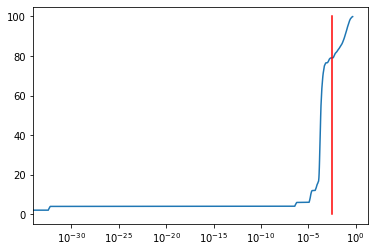

In [22]:
# Get betas
betas = np.zeros((tm_settings["n_topics"], tm_settings["vocab_size"]))
with open(modeldir.joinpath('word-topic-counts.txt').resolve().as_posix(), 'r', encoding='utf8') as fin:
    for line in fin.readlines():
        tokens = line.split()[1:]
        pos = int(tokens[0][2:])
        for el in tokens[1:]:
            tpc = int(el.split(':')[0])
            cnt = int(el.split(':')[1])
            betas[tpc,pos] = cnt

betas = normalize(betas,axis=1,norm='l1')

# Get thetas
thetas = np.loadtxt(modeldir.joinpath('doc-topics.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]
printgr(thetas.shape)

thetas_mallet_centr = thetas

plot_thetas(thetas)

thetas[thetas<3e-3] = 0
thetas = normalize(thetas,axis=1,norm='l1')
thetas_theoretical = doc_topics_all[0][0:n_docs]


# Eval betas and thetas
betas_21 = eval_betas(betas, topic_vectors)
thetas_21 = eval_thetas(thetas_theoretical, thetas, n_docs)

In [23]:
# Baseline
thetas_31 = eval_thetas(thetas_theoretical, inf2_doc_topics, n_docs)

Difference in evaluation of doc similarity:
425.83504337880447


In [24]:
thetas_21_prom = []
for node_i in range(n_nodes):
    thetas_theoretical = doc_topics_all[node_i][0:n_docs]
    thetas_eval = eval_thetas(thetas_theoretical, thetas, n_docs)
    thetas_21_prom.append(thetas_eval)
thetas_21_prom = sum(thetas_21_prom)/n_nodes
thetas_21_prom

Difference in evaluation of doc similarity:
173.1887282984331
Difference in evaluation of doc similarity:
183.17954197770365
Difference in evaluation of doc similarity:
187.12873218719466
Difference in evaluation of doc similarity:
187.11893540263515
Difference in evaluation of doc similarity:
186.85977045348295


183.4951416638899

In [25]:
# Dif 5000x5000 
thetas = np.loadtxt(modeldir.joinpath('doc-topics.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:]#[:n_docs,:]

for i in range(len(doc_topics_all)):
    if i == 0:
        doc_topics = doc_topics_all[i][0:n_docs]
    else:
        doc_topics = np.concatenate((doc_topics,doc_topics_all[i][0:n_docs])) 
print(doc_topics.shape)

thetas_theoretical = doc_topics

thetas_21_5000 = eval_thetas(thetas_theoretical, thetas, n_docs*n_nodes)

(5000, 50)
Difference in evaluation of doc similarity:
317.16650403384966


#### 2.1.1. Inference on the centralized approach with `inf1`

In [26]:
# Define inference corpus
corpus_inf = inf1[0:n_docs]
print(len(corpus_inf))

# Perform inference
extractPipe(modeldir)
inference(modeldir, corpus_inf)

1000
-- Extracting pipeline
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus.mallet --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus_aux.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/import.pipe
-- Inference: Mallet Data Import
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/import.pipe --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus_inf.txt --output /export/usuarios_ml4ds/lbartolome/data/pro

In [27]:
# Get inferred thetas
thetas_inf = np.loadtxt(modeldir.joinpath('doc-topics-inf.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]
thetas_inf[thetas_inf<3e-3] = 0
thetas_inf = normalize(thetas_inf,axis=1,norm='l1')
print(thetas_inf.shape)
thetas_theoretical = doc_topics_all[0][n_docs:(n_docs+n_docs_inf)]
print(thetas_theoretical.shape)

# Eval thetas
thetas_211 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

(1000, 50)
(1000, 50)
Difference in evaluation of doc similarity:
86.68024007008546


#### 2.1.2. Inference on the centralized approach with `inf2`

In [28]:
# Define inference corpus
corpus_inf = inf2
print(len(corpus_inf))

# Perform inference
extractPipe(modeldir)
inference(modeldir, corpus_inf)

1000
-- Extracting pipeline
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus.mallet --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus_aux.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/import.pipe
-- Inference: Mallet Data Import
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/import.pipe --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_centralized/corpus_inf.txt --output /export/usuarios_ml4ds/lbartolome/data/pro

In [29]:
# Get inferred thetas
thetas_inf = np.loadtxt(modeldir.joinpath('doc-topics-inf.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]
thetas_inf[thetas_inf<3e-3] = 0
thetas_inf = normalize(thetas_inf,axis=1,norm='l1')
print(thetas_inf.shape)
thetas_theoretical = inf2_doc_topics
print(thetas_theoretical.shape)
# Eval thetas
thetas_212 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

(1000, 50)
(1000, 50)
Difference in evaluation of doc similarity:
55.74460220762299


### *2.2. Just in one node approach*

In [30]:
# Define corpus
corpus = documents_all[0][0:n_docs]
print(len(corpus))

# Train model 
modelname = "mallet_node0"
modeldir = train(modelname, modelsdir, corpus)

1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0_old
-- -- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "[\p{L}\p{N}][\p{L}\p{N}\p{P}]*" --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus.mallet
/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet train-topics --config /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/trainconfig.json
-- -- Training mallet topic model. Command is /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet t

Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 249
total tokens: 198744
<10> LL/token: -8.9403
<20> LL/token: -8.39206
<30> LL/token: -8.19762
<40> LL/token: -8.07208

0	0.02	wd255 wd3555 wd795 wd296 wd996 wd1830 wd31 wd3986 wd1193 wd3899 wd3808 wd4586 wd4441 wd2362 wd1219 wd3882 wd1820 wd347 wd2381 wd2702 
1	0.02	wd4954 wd383 wd2115 wd4391 wd641 wd3311 wd256 wd2264 wd4286 wd54 wd3538 wd1372 wd1508 wd1789 wd1208 wd2391 wd2960 wd4741 wd1274 wd2619 
2	0.02	wd1274 wd4043 wd2154 wd641 wd256 wd1990 wd2391 wd539 wd3795 wd54 wd364 wd4604 wd4986 wd1789 wd707 wd3665 wd1802 wd550 wd2829 wd1873 
3	0.02	wd2496 wd1253 wd4136 wd28 wd1494 wd948 wd3408 wd1300 wd4390 wd4203 wd383 wd365 wd3604 wd2478 wd229 wd699 wd4730 wd1208 wd4899 wd4286 
4	0.02	wd43 wd2773 wd693 wd2939 wd3909 wd2675 wd3522 wd2463 wd3163 wd1494 wd3276 wd329 wd1159 wd3747 wd602 wd474 wd4787 wd4505 wd699 wd3996 
5	0.02	wd2593 wd4914 wd3847 wd948 wd3625 wd803 wd2143 wd988 wd1177 wd1489 wd4066 wd3314 wd204

<110> LL/token: -7.74914
<120> LL/token: -7.72772
<130> LL/token: -7.70803
<140> LL/token: -7.6945

0	0.02	wd3555 wd255 wd795 wd3986 wd1830 wd996 wd31 wd296 wd1193 wd3899 wd3808 wd4586 wd1219 wd4441 wd3882 wd2381 wd4826 wd3311 wd3941 wd1820 
1	0.02	wd4954 wd383 wd2115 wd1372 wd1789 wd1208 wd4391 wd4741 wd2391 wd256 wd4188 wd3311 wd641 wd2264 wd1508 wd1073 wd54 wd707 wd1902 wd4979 
2	0.02	wd256 wd2154 wd641 wd4043 wd1274 wd4604 wd54 wd3795 wd2391 wd1379 wd539 wd1990 wd364 wd707 wd3665 wd1789 wd4986 wd4608 wd2933 wd1802 
3	0.02	wd4136 wd2496 wd1253 wd383 wd28 wd1300 wd1494 wd699 wd4390 wd3408 wd4203 wd2478 wd948 wd2264 wd525 wd4351 wd2170 wd229 wd3669 wd1208 
4	0.02	wd2773 wd693 wd3909 wd43 wd2675 wd2939 wd3163 wd2330 wd3276 wd1494 wd602 wd2463 wd3187 wd3092 wd4505 wd3625 wd3747 wd2977 wd822 wd1620 
5	0.02	wd3847 wd4914 wd3625 wd2593 wd794 wd4597 wd948 wd310 wd3637 wd4954 wd4066 wd803 wd3314 wd1489 wd988 wd2143 wd3522 wd4586 wd360 wd3885 
6	0.02	wd2593 wd3847 wd3625 wd4914 wd794 wd310 wd

[beta: 0.02662] 
<210> LL/token: -7.57901
[beta: 0.03355] 
<220> LL/token: -7.68835
[beta: 0.03674] 
<230> LL/token: -7.75928
[beta: 0.03732] 
<240> LL/token: -7.77259

0	0.11413	wd3555 wd255 wd996 wd1830 wd795 wd296 wd31 wd1193 wd3986 wd3899 wd3808 wd4441 wd4586 wd1219 wd3882 wd1820 wd2381 wd1568 wd2193 wd4826 
1	0.04311	wd4954 wd383 wd3311 wd4136 wd4188 wd1789 wd360 wd2391 wd2782 wd4979 wd3562 wd1372 wd2115 wd4230 wd3899 wd3555 wd1820 wd3155 wd400 wd325 
2	0.17728	wd256 wd2154 wd641 wd4043 wd1274 wd3795 wd2391 wd1379 wd54 wd1990 wd4604 wd1789 wd364 wd539 wd3665 wd707 wd4986 wd1802 wd4608 wd4825 
3	0.06546	wd4136 wd2496 wd1253 wd1494 wd4390 wd2478 wd3408 wd1208 wd4203 wd28 wd365 wd3895 wd1300 wd3740 wd3669 wd2527 wd1830 wd383 wd2264 wd525 
4	0.05073	wd693 wd2773 wd3909 wd3163 wd2675 wd2939 wd43 wd4505 wd1494 wd3522 wd3276 wd4193 wd2806 wd822 wd3092 wd3928 wd3187 wd2463 wd3452 wd602 
5	0.05698	wd3847 wd4914 wd2593 wd948 wd310 wd794 wd4597 wd4066 wd3625 wd3314 wd803 wd704 wd988 wd3637 w

[beta: 0.03493] 
<310> LL/token: -7.69667
[beta: 0.03431] 
<320> LL/token: -7.66385
[beta: 0.03362] 
<330> LL/token: -7.63877
[beta: 0.03345] 
<340> LL/token: -7.61311

0	0.2686	wd255 wd3555 wd996 wd1193 wd1830 wd296 wd3986 wd795 wd31 wd3808 wd4586 wd3899 wd1219 wd4441 wd3882 wd1820 wd2183 wd3311 wd2716 wd347 
1	0.01266	wd2477 wd400 wd1691 wd4136 wd2420 wd440 wd2893 wd859 wd3521 wd1913 wd191 wd1852 wd3458 wd4186 wd2597 wd3049 wd3689 wd3740 wd3736 wd4899 
2	0.46248	wd256 wd2154 wd641 wd54 wd3795 wd4043 wd1274 wd1379 wd1990 wd1789 wd2391 wd4604 wd539 wd364 wd707 wd1802 wd4986 wd3665 wd2933 wd4608 
3	0.02831	wd1494 wd4390 wd4203 wd4448 wd1865 wd2264 wd3450 wd3485 wd1689 wd1982 wd3184 wd4606 wd1073 wd3669 wd368 wd2758 wd2781 wd2186 wd4496 wd3895 
4	0.02192	wd4505 wd3213 wd2522 wd3123 wd3276 wd3452 wd4193 wd589 wd2828 wd2956 wd2287 wd4334 wd3989 wd1893 wd2675 wd2667 wd513 wd248 wd2922 wd1193 
5	0.02222	wd255 wd3847 wd3781 wd2933 wd4023 wd948 wd890 wd3618 wd2925 wd1602 wd1298 wd792 wd3749 wd

[beta: 0.033] 
<410> LL/token: -7.46083
[beta: 0.033] 
<420> LL/token: -7.44102
[beta: 0.03316] 
<430> LL/token: -7.42875
[beta: 0.03369] 
<440> LL/token: -7.41856

0	0.39883	wd255 wd3555 wd996 wd795 wd3986 wd296 wd1830 wd1193 wd31 wd3899 wd3808 wd4586 wd4441 wd1219 wd3882 wd3311 wd2183 wd2381 wd2362 wd1820 
1	0.00129	wd1913 wd1852 wd1691 wd3035 wd2597 wd2813 wd4439 wd2719 wd3920 wd1110 wd4368 wd151 wd823 wd1660 wd3458 wd3825 wd4533 wd1279 wd1614 wd400 
2	0.62729	wd256 wd2154 wd54 wd3795 wd641 wd1274 wd4043 wd1379 wd1990 wd2391 wd1789 wd539 wd4604 wd364 wd707 wd3665 wd2933 wd1802 wd4986 wd4608 
3	0.00225	wd3485 wd2238 wd3304 wd2204 wd2127 wd4448 wd4611 wd3450 wd3559 wd1623 wd4399 wd1111 wd2251 wd3570 wd314 wd2941 wd2220 wd2161 wd354 wd4111 
4	0.00846	wd3213 wd4762 wd3452 wd1775 wd3989 wd2922 wd2667 wd4468 wd3412 wd2791 wd513 wd228 wd2528 wd1757 wd3847 wd4144 wd104 wd4665 wd4162 wd3099 
5	0.00065	wd1313 wd2261 wd4537 wd1851 wd1643 wd265 wd3359 wd1596 wd948 wd4279 wd1391 
6	0.69197	wd259

[beta: 0.0341] 
<510> LL/token: -7.33026
[beta: 0.03409] 
<520> LL/token: -7.31997
[beta: 0.03461] 
<530> LL/token: -7.3082
[beta: 0.03501] 
<540> LL/token: -7.29626

0	0.49567	wd255 wd3555 wd996 wd795 wd1830 wd3986 wd1193 wd296 wd31 wd3899 wd4441 wd3808 wd1219 wd4586 wd3882 wd2381 wd2183 wd3941 wd3311 wd1568 
1	0.00164	wd1913 wd1852 wd4972 wd3014 wd753 wd610 wd4935 wd2394 wd4439 wd2719 wd3920 wd1110 wd4368 wd260 wd1691 wd3458 wd4193 wd2778 wd1539 wd220 
2	0.67952	wd256 wd2154 wd54 wd3795 wd641 wd1379 wd1274 wd4043 wd2391 wd1990 wd1789 wd4604 wd539 wd364 wd707 wd2933 wd3665 wd1802 wd4986 wd4608 
3	0.00033	wd3485 wd2238 wd3304 wd2204 wd4707 wd4448 wd2496 wd3559 wd4399 wd2109 wd314 wd68 wd1865 wd4562 wd3302 wd4430 wd4099 wd1043 wd4813 wd3450 
4	0.00066	wd650 wd3246 wd4662 wd534 wd2438 wd1842 wd3185 wd1161 wd1415 wd711 wd4306 wd866 wd327 wd4769 wd4154 wd4597 wd165 wd3989 wd444 wd795 
5	0.00165	wd1313 wd2261 wd4537 wd1851 wd3443 wd4227 wd1688 wd154 wd4284 wd4140 wd91 wd265 wd3355 wd4243 wd

[beta: 0.03638] 
<610> LL/token: -7.22574
[beta: 0.03664] 
<620> LL/token: -7.22297
[beta: 0.03743] 
<630> LL/token: -7.21536
[beta: 0.03802] 
<640> LL/token: -7.2057

0	0.64412	wd255 wd3555 wd795 wd996 wd1830 wd3986 wd1193 wd31 wd296 wd3899 wd3808 wd1219 wd4441 wd4586 wd3311 wd3882 wd2183 wd2381 wd2362 wd3615 
1	0.00033	wd1852 wd1913 wd4935 wd2394 wd4439 wd2719 wd3920 wd4368 wd4029 wd1691 wd1257 wd3763 wd1936 wd4027 wd4136 wd3736 wd2502 wd1395 wd1634 wd980 
2	0.70562	wd256 wd2154 wd54 wd3795 wd1379 wd641 wd1274 wd4043 wd1990 wd2391 wd1789 wd4604 wd539 wd707 wd364 wd1802 wd4986 wd2933 wd3665 wd4608 
3	0.00033	wd3485 wd2238 wd3304 wd2204 wd2341 wd3559 wd4399 wd2109 wd1111 wd314 wd2941 wd1619 wd1660 wd4372 wd4707 wd354 wd3122 wd1865 wd678 wd2127 
4	0.00132	wd650 wd2752 wd3246 wd1034 wd4662 wd534 wd2438 wd4963 wd1842 wd711 wd4734 wd1499 wd4306 wd4394 wd82 wd327 wd2025 wd165 wd2925 wd3989 
5	0.00132	wd1313 wd4629 wd2372 wd2261 wd4537 wd1851 wd2185 wd575 wd1194 wd1688 wd3045 wd265 wd3199 wd

[beta: 0.03947] 
<710> LL/token: -7.17331
[beta: 0.0397] 
<720> LL/token: -7.17447
[beta: 0.04015] 
<730> LL/token: -7.16765
[beta: 0.04012] 
<740> LL/token: -7.17052

0	0.7314	wd255 wd3555 wd795 wd996 wd3986 wd31 wd296 wd1830 wd1193 wd3899 wd3808 wd1219 wd4441 wd4586 wd2362 wd3311 wd3615 wd3882 wd2381 wd2183 
1	0.00133	wd1852 wd1913 wd4935 wd2394 wd4439 wd2719 wd3920 wd1110 wd4368 wd1462 wd2359 wd1691 wd4667 wd1408 wd4212 wd859 wd1919 wd879 wd231 wd4441 
2	0.72214	wd256 wd2154 wd641 wd3795 wd1274 wd54 wd4043 wd1379 wd4604 wd1990 wd2391 wd1789 wd364 wd539 wd707 wd3665 wd4986 wd2933 wd1802 wd4608 
3	0.00099	wd3485 wd2238 wd3304 wd2204 wd4707 wd3559 wd4399 wd2109 wd2941 wd1625 wd2493 wd3274 wd4498 wd678 wd1640 wd368 wd4448 wd4903 wd4562 wd2385 
4	0.00133	wd650 wd4717 wd418 wd218 wd4662 wd534 wd2438 wd1842 wd1161 wd3536 wd541 wd327 wd3993 wd3644 wd3013 
5	0.00431	wd1313 wd1688 wd14 wd3199 wd1204 wd4100 wd272 wd344 wd2261 wd1851 wd4091 wd4205 wd3043 wd60 wd4084 wd3752 wd1792 wd1111 wd3791 

[beta: 0.04179] 
<810> LL/token: -7.16189
[beta: 0.04234] 
<820> LL/token: -7.16557
[beta: 0.04198] 
<830> LL/token: -7.1645
[beta: 0.04236] 
<840> LL/token: -7.17025

0	0.74742	wd255 wd3555 wd795 wd996 wd1830 wd3986 wd31 wd296 wd1193 wd3899 wd3808 wd1219 wd4586 wd4441 wd2362 wd3311 wd1568 wd3882 wd2381 wd3615 
1	0.00066	wd1852 wd1913 wd4935 wd2394 wd4439 wd2719 wd3920 wd1110 wd4368 wd3763 wd1367 wd3123 wd1268 wd1919 wd2698 wd3736 wd2856 
2	0.70925	wd256 wd2154 wd641 wd3795 wd54 wd1379 wd1274 wd4043 wd1990 wd2391 wd1789 wd4604 wd364 wd539 wd707 wd4986 wd3665 wd1802 wd4608 wd2933 
3	0.00099	wd3485 wd2238 wd3304 wd2204 wd2220 wd2613 wd3559 wd4399 wd1172 wd2464 wd3458 wd4372 wd354 wd3274 wd3122 wd678 wd4448 wd4562 wd775 wd3049 
4	0.0033	wd3246 wd1953 wd650 wd2752 wd2313 wd2113 wd3051 wd3190 wd4662 wd534 wd2438 wd4963 wd1842 wd3185 wd1161 wd2577 wd1382 wd2173 wd2345 wd3173 
5	0.00264	wd1313 wd1688 wd1820 wd2261 wd4537 wd1851 wd1398 wd2285 wd4084 wd3752 wd1792 wd1415 wd1476 wd3220 wd2948 wd

[beta: 0.04169] 
<910> LL/token: -7.15308
[beta: 0.04134] 
<920> LL/token: -7.14951
[beta: 0.04209] 
<930> LL/token: -7.15523
[beta: 0.04212] 
<940> LL/token: -7.15818

0	0.73775	wd255 wd3555 wd795 wd996 wd1830 wd3986 wd31 wd296 wd1193 wd3899 wd3808 wd1219 wd4441 wd4586 wd2362 wd3311 wd3615 wd3882 wd1568 wd2381 
1	0.0033	wd1913 wd1852 wd4394 wd980 wd4935 wd4439 wd3920 wd1110 wd4773 wd3179 wd1793 wd3763 wd573 wd2159 wd3586 wd1903 wd4174 wd1045 wd2522 wd4236 
2	0.70582	wd256 wd2154 wd641 wd3795 wd1379 wd54 wd4043 wd1274 wd2391 wd1990 wd4604 wd1789 wd707 wd364 wd539 wd1802 wd3665 wd2933 wd4986 wd4608 
3	0.00165	wd3485 wd2238 wd3304 wd2204 wd3450 wd3559 wd854 wd4399 wd2109 wd4270 wd1111 wd314 wd2941 wd3827 wd2220 wd3458 wd4372 wd1625 wd4523 wd3274 
4	0.00033	wd650 wd2635 wd1006 wd3644 wd4662 wd534 wd2438 wd4963 wd1842 wd1161 wd541 wd1323 wd3989 wd2821 wd3984 wd2416 wd3808 wd792 
5	0.00132	wd1194 wd2968 wd1034 wd3190 wd2589 wd2860 wd4378 wd2524 wd2716 wd2112 wd2593 
6	0.77287	wd2593 wd3847 

(1000, 50)
Tópicos (equivalentes) evaluados correctamente:
16.471423002736326
Difference in evaluation of doc similarity:
43.22624225269518


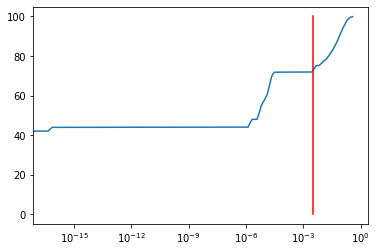

In [31]:
# Get betas
betas = np.zeros((tm_settings["n_topics"], tm_settings["vocab_size"]))
with open(modeldir.joinpath('word-topic-counts.txt').resolve().as_posix(), 'r', encoding='utf8') as fin:
    for line in fin.readlines():
        tokens = line.split()[1:]
        pos = int(tokens[0][2:])
        for el in tokens[1:]:
            tpc = int(el.split(':')[0])
            cnt = int(el.split(':')[1])
            betas[tpc,pos] = cnt

betas = normalize(betas,axis=1,norm='l1')

# Get thetas
thetas = np.loadtxt(modeldir.joinpath('doc-topics.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]

plot_thetas(thetas)

thetas_mallet = thetas
thetas[thetas<3e-3] = 0
thetas = normalize(thetas,axis=1,norm='l1')
thetas_theoretical = doc_topics_all[0][0:n_docs]
print(thetas_theoretical.shape)


# Eval betas and thetas
betas_22 = eval_betas(betas, topic_vectors)
thetas_22 = eval_thetas(thetas_theoretical, thetas, n_docs)

#### 2.2.1. Inference on the just in one node approach with `inf1`

In [32]:
# Define inference corpus
corpus_inf = inf1[0:n_docs] #documents_all[0][n_docs:(n_docs+n_docs_inf)]
print(len(corpus_inf))

# Perform inference
extractPipe(modeldir)
inference(modeldir, corpus_inf)

1000
-- Extracting pipeline
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus.mallet --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus_aux.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/import.pipe
-- Inference: Mallet Data Import
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/import.pipe --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus_inf.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated

In [33]:
# Get inferred thetas
thetas_inf = np.loadtxt(modeldir.joinpath('doc-topics-inf.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]
thetas_inf[thetas_inf<3e-3] = 0
thetas_inf = normalize(thetas_inf,axis=1,norm='l1')
print(thetas_inf.shape)

thetas_theoretical = doc_topics_all[0][n_docs:(n_docs+n_docs_inf)]
print(thetas_theoretical.shape)

# Eval thetas
thetas_221 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

(1000, 50)
(1000, 50)
Difference in evaluation of doc similarity:
25.61966808854473


#### 2.2.2. Inference on the just in one node approach with `inf2`

In [34]:
# Define inference corpus
corpus_inf = inf2
print(len(corpus_inf))

# Perform inference
extractPipe(modeldir)
inference(modeldir, corpus_inf)

1000
-- Extracting pipeline
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus.mallet --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus_aux.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/import.pipe
-- Inference: Mallet Data Import
-- Running command /export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/src/topicmodeling/mallet-2.0.8/bin/mallet import-file --use-pipe-from /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/import.pipe --input /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/mallet_node0/corpus_inf.txt --output /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated

In [35]:
# Get inferred thetas
thetas_inf = np.loadtxt(modeldir.joinpath('doc-topics-inf.txt').resolve().as_posix(), delimiter='\t', dtype=np.float32)[:,2:][:n_docs,:]
thetas_inf[thetas_inf<3e-3] = 0
thetas_inf = normalize(thetas_inf,axis=1,norm='l1')
print(thetas_inf.shape)
thetas_theoretical = inf2_doc_topics
print(thetas_theoretical.shape)

# Eval thetas
thetas_222 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

(1000, 50)
(1000, 50)
Difference in evaluation of doc similarity:
249.38323179043797


## **3. ProdLDA**


---

In [36]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [37]:
cd /export/usuarios_ml4ds/lbartolome/topicmodeler

/export/usuarios_ml4ds/lbartolome/topicmodeler


In [38]:
from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM

### *Auxiliary functions*

In [39]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_distribution()
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [40]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    train_bow = cv.fit_transform(docs).toarray()
    idx2token = cv.get_feature_names_out()
    train_dataset = BOWDataset(train_bow, idx2token)
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    avitm = AVITM(logger=None,
              input_size=input_size,
              n_components=n_topics,
              model_type="prodLDA",
              hidden_sizes=(100, 100),
              activation='softplus',
              dropout=0.2,
              learn_priors=True,
              batch_size=64,
              lr=2e-3,
              momentum=0.99,
              solver='adam',
              num_epochs=100,
              reduce_on_plateau=False,
              topic_prior_mean=0.0,
              topic_prior_variance=None,
              num_samples=10,
              num_data_loader_workers=0,
              verbose=True)
    avitm.fit(train_dataset)
    
    return modeldir, avitm, cv, id2token, idx2token

### *3.1. Centralized approach*

In [41]:
# Define corpus
corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
print(len(corpus))

# Train model 
modelname = "prod_centralized"
modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


Epoch: [100/100]	 Seen Samples: [500000/500000]	Train Loss: 1562.22168984375	Time: 0:00:01.591792: : 100it [02:36,  1.56s/it] 
Sampling: [20/20]: : 20it [00:23,  1.18s/it]


Sampling: [20/20]: : 20it [00:24,  1.20s/it]


Tópicos (equivalentes) evaluados correctamente:
8.557336565975119
Difference in evaluation of doc similarity:
90.50660056182532


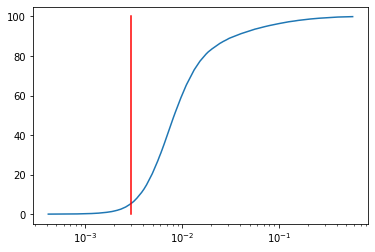

In [42]:
# Get betas
betas = avitm.get_topic_word_distribution()
all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                        model=avitm,
                                        model_type="avitm",
                                        ntopics=n_topics,
                                        id2token=id2token,
                                        all_words=all_words)

# Get thetas
thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]

plot_thetas(thetas)

thetas_prod_centr = thetas
thetas[thetas < 3e-3] = 0
thetas = normalize(thetas, axis=1, norm='l1')
thetas_theoretical = doc_topics_all[0][0:n_docs]



# Eval betas and thetas
betas_31 = eval_betas(betas, topic_vectors)
thetas_31 = eval_thetas(thetas_theoretical, thetas, n_docs)

#### 3.1.1. Inference on the centralized approach with `inf1`

In [43]:
# Define inference corpus
corpus_inf = inf1[0:n_docs]
print(len(corpus_inf))


# Get inferred thetas
docs_val_conv = [" ".join(corpus_inf[i]) for i in np.arange(len(corpus_inf))]
val_bow = cv.transform(docs_val_conv)
val_bow = val_bow.toarray()
val_data = BOWDataset(val_bow, idx2token)

thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))[0:n_docs,:]
thetas_inf[thetas_inf < 3e-3] = 0
thetas_inf = normalize(thetas_inf, axis=1, norm='l1')

thetas_theoretical = doc_topics_all[0][n_docs:(n_docs+n_docs_inf)]

# Eval thetas
thetas_311 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

1000


Sampling: [20/20]: : 20it [00:19,  1.01it/s]

Difference in evaluation of doc similarity:
90.62438281065909


#### 3.1.2. Inference on the centralized approach with `inf2`

In [44]:
# Define inference corpus
corpus_inf = inf2
print(len(corpus_inf))

# Get inferred thetas
docs_val_conv = [" ".join(corpus_inf[i]) for i in np.arange(len(corpus_inf))]
val_bow = cv.transform(docs_val_conv)
val_bow = val_bow.toarray()
val_data = BOWDataset(val_bow, idx2token)

thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))[0:n_docs,:]
thetas_inf[thetas_inf < 3e-3] = 0
thetas_inf = normalize(thetas_inf, axis=1, norm='l1')

thetas_theoretical = inf2_doc_topics

# Eval thetas
thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

1000


Sampling: [20/20]: : 20it [00:19,  1.00it/s]

Difference in evaluation of doc similarity:
330.4249697468007


### *3.2. Just in one node approach*

1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node0_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


Epoch: [100/100]	 Seen Samples: [100000/100000]	Train Loss: 1518.82873828125	Time: 0:00:01.100930: : 100it [01:54,  1.15s/it]
Sampling: [20/20]: : 20it [00:21,  1.06s/it]
Sampling: [20/20]: : 20it [00:18,  1.10it/s]


Tópicos (equivalentes) evaluados correctamente:
6.46703788225029
Difference in evaluation of doc similarity:
143.379945858464


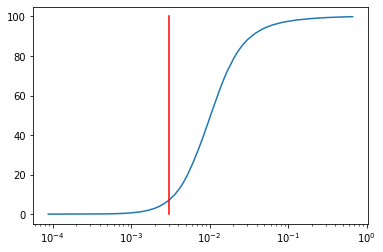

In [45]:
# Define corpus
corpus = documents_all[0][0:n_docs]
print(len(corpus))

# Train model 
modelname = "prodlda_node0"
modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

# Get betas
betas = avitm.get_topic_word_distribution()
all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                        model=avitm,
                                        model_type="avitm",
                                        ntopics=n_topics,
                                        id2token=id2token,
                                        all_words=all_words)

# Get thetas
thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))

plot_thetas(thetas)

thetas_prod = thetas
thetas[thetas < 3e-3] = 0
thetas = normalize(thetas, axis=1, norm='l1')
thetas_theoretical = doc_topics_all[0][0:n_docs]


# Eval betas and thetas
betas_32 = eval_betas(betas, topic_vectors)
thetas_32 = eval_thetas(thetas_theoretical, thetas, n_docs)

#### 3.2.1. Inference on the just in one node approach with `inf1`

In [46]:
# Define inference corpus
corpus_inf = inf1[0:n_docs]#documents_all[0][n_docs:(n_docs+n_docs_inf)]
print(len(corpus_inf))

# Get inferred thetas
docs_val_conv = [" ".join(corpus_inf[i]) for i in np.arange(len(corpus_inf))]
val_bow = cv.transform(docs_val_conv)
val_bow = val_bow.toarray()
val_data = BOWDataset(val_bow, idx2token)

thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))
thetas_inf[thetas_inf < 3e-3] = 0
thetas_inf = normalize(thetas_inf, axis=1, norm='l1')

thetas_theoretical = doc_topics_all[0][n_docs:(n_docs+n_docs_inf)]

# Eval thetas
thetas_321 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

1000


Sampling: [20/20]: : 20it [00:16,  1.19it/s]

Difference in evaluation of doc similarity:
76.42746614778368


#### 2.2.2. Inference on the just in one node approach with `inf2`

In [47]:
# Define inference corpus
corpus_inf = inf2
print(len(corpus_inf))

# Get inferred thetas
docs_val_conv = [" ".join(corpus_inf[i]) for i in np.arange(len(corpus_inf))]
val_bow = cv.transform(docs_val_conv)
val_bow = val_bow.toarray()
val_data = BOWDataset(val_bow, idx2token)

thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))
thetas_inf[thetas_inf < 3e-3] = 0
thetas_inf = normalize(thetas_inf, axis=1, norm='l1')

thetas_theoretical = inf2_doc_topics

# Eval thetas
thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, n_docs_inf)

1000


Sampling: [20/20]: : 20it [00:17,  1.14it/s]

Difference in evaluation of doc similarity:
476.70332425685365


## **4. Test alpha influence**


---

In [48]:
thetas_theoretical_node0 = doc_topics_all[0]

for i in range(len(doc_topics_all)):
    if i == 0:
        thetas_theoretical_all = doc_topics_all[i]
    else:
        thetas_theoretical_all = np.concatenate((thetas_theoretical_all,doc_topics_all[i])) 

In [49]:
alphas_test = [50 * el for el in [100, 10, 1, 0.1, 0.01]]

results_node0 = []
results_all = []

for alpha_iter in alphas_test:
    tm_settings["alpha"] = alpha_iter/tm_settings["n_topics"]

    topic_vectors, doc_topics_all, _ = generateSynthetic(False, False, **tm_settings, **centralized_settings)

    thetas_theoretical_node0_it = doc_topics_all[0]

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_theoretical_all_it = doc_topics_all[i]
        else:
            thetas_theoretical_all_it = np.concatenate((thetas_theoretical_all_it,doc_topics_all[i]))

    results_node0.append(eval_thetas(thetas_theoretical_node0, thetas_theoretical_node0_it, 2000)) 
    results_all.append(eval_thetas(thetas_theoretical_all, thetas_theoretical_all_it, 10000)) 

Difference in evaluation of doc similarity:
157.85138461794625
Difference in evaluation of doc similarity:
902.0833012632031
Difference in evaluation of doc similarity:
158.20076476359867
Difference in evaluation of doc similarity:
912.6507918652702
Difference in evaluation of doc similarity:
158.3970684603421
Difference in evaluation of doc similarity:
916.1158928770918
Difference in evaluation of doc similarity:
158.51602306539846
Difference in evaluation of doc similarity:
904.6610507146979
Difference in evaluation of doc similarity:
158.52736386085118
Difference in evaluation of doc similarity:
909.7537501363689


## **5. Results comparison**


---

In [50]:
print("_"*115)
print(f"{'Mallet-Centr':>50}\
        {'Mallet-Node0':>8}\
        {'ProdLDA-Centr':>6}\
        {'ProdLDA-Node0':>10}"
     )
print("-"*115)
print(f"{'Nr topics correctly evaluated:':<30}\
        {betas_21:>10.3f}\
        {betas_22:>11.3f}\
        {betas_31:>13.3f}\
        {betas_32:>13.3f}"
     )
print(f"{'Difference in doc sim:':<30}\
        {thetas_21:>10.3f}\
        {thetas_22:>11.3f}\
        {thetas_31:>13.3f}\
        {thetas_32:>13.3f}"
     )
print(f"{'Difference in doc sim inf1:':<30}\
        {thetas_211:>10.3f}\
        {thetas_221:>11.3f}\
        {thetas_311:>13.3f}\
        {thetas_321:>13.3f}"
     )
print(f"{'Difference in doc sim inf2:':<30}\
        {thetas_212:>10.3f}\
        {thetas_222:>11.3f}\
        {thetas_312:>13.3f}\
        {thetas_322:>13.3f}"
     )
print("_"*115)
print()

print("_"*115)
print(f"{'Stats':<15}\
        {'Nr nodes':>8}\
        {'Nr topics':>8}\
        {'Nr frozen':>8}\
        {'Alpha':>8}\
        {'Beta':>8}\
        {'Ndocs':>8}"
     )
print("-"*115)
print(f"{'':>15}\
        {n_nodes:>8}\
        {n_topics:>8}\
        {frozen_topics:>8}\
        {alpha:>8}\
        {beta:>8}\
        {n_docs:>8}"
     )
print("_"*115)

___________________________________________________________________________________________________________________
                                      Mallet-Centr        Mallet-Node0        ProdLDA-Centr        ProdLDA-Node0
-------------------------------------------------------------------------------------------------------------------
Nr topics correctly evaluated:            37.439             16.471                8.557                6.467
Difference in doc sim:                   173.189             43.226               90.507              143.380
Difference in doc sim inf1:               86.680             25.620               90.624               76.427
Difference in doc sim inf2:               55.745            249.383              330.425              476.703
___________________________________________________________________________________________________________________

__________________________________________________________________________________________________

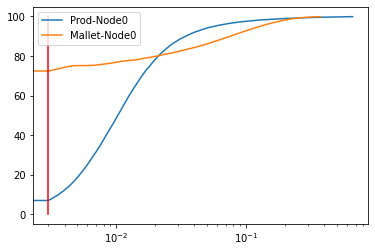

In [51]:
thetas_thr = 3e-3
allvalues = np.sort(thetas_prod.flatten())
step = int(np.round(len(allvalues) / 1000))
plt.semilogx(allvalues[::step], (100 / len(allvalues))
             * np.arange(0, len(allvalues))[::step], label="Prod-Node0")
allvalues2 = np.sort(thetas_mallet.flatten())
plt.semilogx(allvalues2[::step], (100 / len(allvalues2))
             * np.arange(0, len(allvalues2))[::step], label="Mallet-Node0")
plt.semilogx([thetas_thr, thetas_thr], [0, 100], 'r')
plt.legend(loc="upper left")

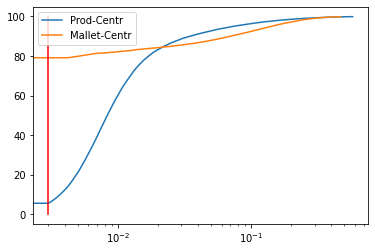

In [52]:
allvalues = np.sort(thetas_prod_centr.flatten())
step = int(np.round(len(allvalues) / 1000))
plt.semilogx(allvalues[::step], (100 / len(allvalues))
             * np.arange(0, len(allvalues))[::step], label="Prod-Centr")
allvalues2 = np.sort(thetas_mallet_centr.flatten())
plt.semilogx(allvalues2[::step], (100 / len(allvalues2))
             * np.arange(0, len(allvalues2))[::step], label="Mallet-Centr")
plt.semilogx([thetas_thr, thetas_thr], [0, 100], 'r')
plt.legend(loc="upper left")

In [55]:
rows_select = np.arange(10000)
rows_select

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])